In [10]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
import edward2 as ed
tfd = tfp.distributions

sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.random.set_seed(111)

In [11]:
# Settings
D = 4   #number of dimensions
N = 100 #number of datapoints to generate
noise_std_true = 1.0

# Generate data
b_true = np.random.randn(1).astype(np.float32)    #bias (alpha)
w_true = np.random.randn(D, 1).astype(np.float32) #weights (beta)
x = np.random.randn(N, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N,1).astype(np.float32)
y = np.matmul(x, w_true) + b_true + noise

C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C

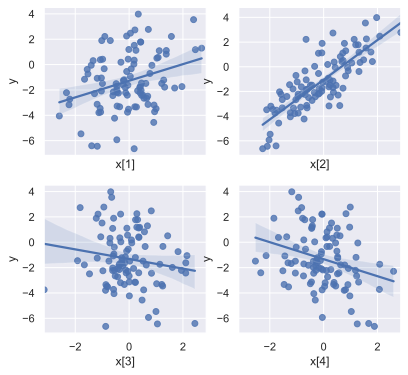

In [12]:
# Show data
fig, axes = plt.subplots(int(np.ceil(D/2)), 2, sharex=True)
fig.set_size_inches(6.4, 6)
for i in range(D):
  t_ax = axes[int(i/2), i%2] #this axis
  sns.regplot(x[:,i], y[:,0], ax=t_ax)
  t_ax.set_ylabel('y')
  t_ax.set_xlabel('x[%d]'%(i+1))
plt.show()

In [13]:
print('True bias: %0.2f' % b_true)
print('True weights: ', w_true[:,0])

True bias: -1.13
True weights:  [ 0.3843192  1.4965538 -0.3553823 -0.7875335]


You can edit cells by double clicking them (the color on the left changes from blue to green) and change the text (not really useful) or code (will be useful).

In [14]:
def linear_regression(features):
  D = features.shape[1]      #number of dimensions
  coeffs = ed.Normal(        #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  bias = ed.Normal(          #normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   #normally-distributed noise
      loc=tf.matmul(features, coeffs)+bias,
      scale=noise_std,
      name="predictions")
  return predictions

In [15]:
# Joint posterior distribution
log_joint = ed.make_log_joint_fn(linear_regression)
print(log_joint)

<function make_log_joint_fn.<locals>.log_joint_fn at 0x000001EE4BF3FB80>


In [16]:
# Function to compute the log posterior probability
def target_log_prob_fn(coeffs, bias, noise_std):
  return log_joint(
      features=x,
      coeffs=coeffs,
      bias=bias,
      noise_std=noise_std,
      predictions=y)

In [17]:
class Timer:
  def __enter__(self):
    self.t0 = time.time()
  def __exit__(self, *args):
    print('Elapsed time: %0.2fs' % (time.time()-self.t0))

In [18]:
with Timer():
  time.sleep(3.14)

Elapsed time: 3.14s


In [19]:
# HMC Settings
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps
step_size = 0.01
num_leapfrog_steps = 10

# Parameter sizes
coeffs_size = [D,1]
bias_size = [1]
noise_std_size = [1]

In [20]:
# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Define the chain states
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ])
coeffs, bias, noise_std = states

C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [21]:


#tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.Session()

In [22]:
#build_pipline requires this
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [23]:

# Run the chain
with Timer(), tf.compat.v1.Session() as sess:
  [
      coeffs_,
      bias_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      tf.constant(coeffs),
      tf.constant(bias),
      tf.constant(noise_std),
      tf.constant(kernel_results.is_accepted),
  ])

# Samples after burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
bias_samples = bias_[n_burnin:]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

Elapsed time: 0.11s


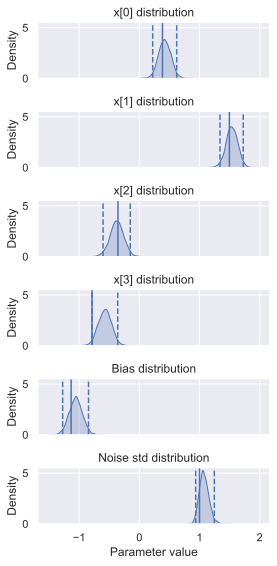

In [24]:
def post_plot(data, title='', ax=None, true=None, prc=95):
  '''Plot the posterior distribution given MCMC samples'''
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  tprc = (100-prc)/2
  ax.axvline(x=np.percentile(data, tprc), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-tprc), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  '''Plot a chain of MCMC samples'''
  post_plot(data, title=title, ax=ax, true=true)
  
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 1, sharex='col', sharey='col')
fig.set_size_inches(4, 8)
for i in range(D):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=w_true[i])
  
# Plot chains and distributions for bias
chain_post_plot(bias_samples[:,0],
                title="Bias",
                ax=axes[D], true=b_true)

# Plot chains and distributions for noise std dev
chain_post_plot(noise_std_samples[:,0],
                title="Noise std",
                ax=axes[D+1], true=noise_std_true)
  
axes[D+1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

In [25]:
# Generate held out data
N_val = 1000
x_val = np.random.randn(N_val, D).astype(np.float32)
noise = noise_std_true*np.random.randn(N_val, 1).astype(np.float32)
y_val = np.matmul(x_val, w_true) + b_true + noise

Text(0.5, 0, 'y')

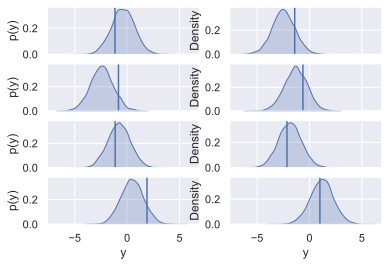

In [26]:
def ind_pred_dist(X):
  '''Compute the prediction distribution'''
  predictions = (np.matmul(X, coeffs_samples.transpose()) + 
                 bias_samples[:,0])
  noise = (noise_std_samples[:,0] * 
           np.random.randn(noise_std_samples.shape[0]))
  return predictions + noise

# Compute prediction distribution for all validation samples
Nmcmc = coeffs_samples.shape[0]
prediction_distribution = np.zeros((N_val, Nmcmc))
for i in range(N_val):
  prediction_distribution[i,:] = ind_pred_dist(x_val[i,:])

# Plot random datapoints and their prediction intervals
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
  axes[i][0].set_ylabel('p(y)')
  
axes[3][0].set_xlabel('y')
axes[3][1].set_xlabel('y')

In [27]:
# Settings
batch_size = 50
max_steps = 2000
learning_rate = 0.005

In [28]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(1)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x, y, x_val, y_val, batch_size, N_val) )

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


In [29]:
def VariationalParameter(name, shape, constraint=None):
  """Generates variational distribution(s)"""
  means = tf.get_variable(name+'_mean', 
                          initializer=tf.ones([1]),
                          constraint=constraint)
  stds = tf.get_variable(name+'_std', 
                         initializer=-2.3*tf.ones([1]))
  return tfd.Normal(loc=means, scale=tf.math.exp(stds))

In [30]:
# A linear regression model: a Normal distribution
# parameterized by location from a single linear layer.
with tf.name_scope("linear_regression", values=[x_vals]):
  layer = tfp.layers.DenseFlipout(
      units=1, 
      activation=None,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
  predictions = layer(x_vals)  
  noise_std = VariationalParameter('noise_std', [1],
                                   constraint=tf.keras.constraints.NonNeg())
  pred_distribution = tfd.Normal(loc=predictions, 
                                 scale=noise_std.sample())

C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [31]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_prob = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum(layer.losses) / N
elbo_loss = neg_log_prob + kl_div

# Mean squared error metric for evaluation
mse, mse_update_op = tf.metrics.mean_squared_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

In [32]:
# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
noise_std_mean = noise_std.mean()
noise_std_std = noise_std.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
noise_means = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  with Timer():
    for iS in range(max_steps):
      [
          _,
          _,
          mses[iS],
          losses[iS],
          weight_means[iS,:],
          weight_stds[iS,:],
          bias_means[iS],
          bias_stds[iS],
          noise_means[iS],
          noise_stds[iS]
      ] = sess.run([
          train_op,
          mse_update_op,
          mse,
          elbo_loss,
          weight_mean,
          weight_std,
          bias_mean,
          bias_std,
          noise_std_mean,
          noise_std_std
      ], feed_dict={handle: train_handle})

  # Draw samples from the posterior
  Nmc = 1000
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  n_draw = noise_std.sample(Nmc)
  w_post, b_post, n_post = sess.run([w_draw, b_draw, n_draw])
  
  # Draw predictive distribution samples
  prediction_dist_var = np.full([Nmc, N_val, 1], np.nan)
  sample_op = pred_distribution.sample(Nmc)
  for iS in range(N_val):
    prediction_dist_var[:, iS, 0] = \
      sess.run(sample_op, feed_dict={handle: val_handle}).ravel()

Elapsed time: 2.97s


In [33]:

print(prediction_dist_var.shape)



(1000, 1000, 1)


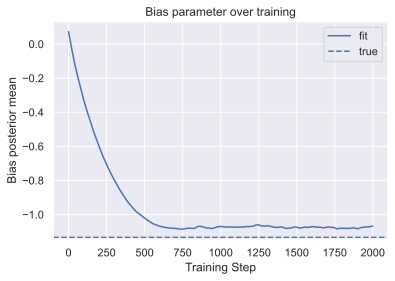

In [34]:
# Plot value of bias over training
plt.figure()
plt.plot(bias_means, label='fit')
plt.axhline(b_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior mean')
plt.title('Bias parameter over training')
plt.legend()
plt.show()

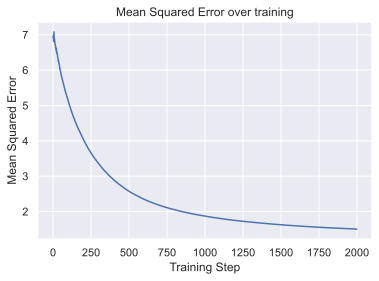

In [35]:
# Plot mean squared error over training
plt.figure()
plt.plot(mses[1:])
plt.xlabel('Training Step')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error over training')
plt.show()

C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\envs\uqdl\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

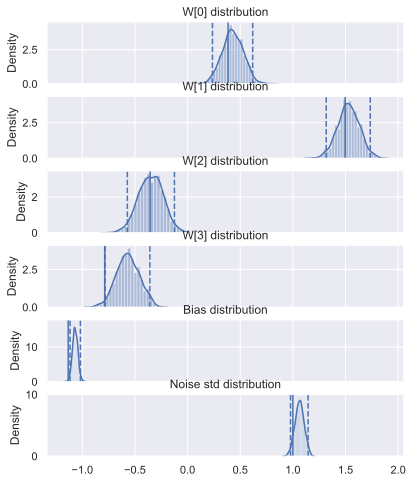

In [36]:
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.distplot(data, ax=ax)
  tprc = (100-prc)/2
  ax.axvline(x=np.percentile(data, tprc), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-tprc), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)

# Plot weight posteriors
fig, axes = plt.subplots(D+2, 1, sharex=True)
fig.set_size_inches(6.4, 8)
for i in range(D):
  post_plot(w_post[:,i,0], title='W[{}]'.format(i), 
            ax=axes[i], true=w_true[i])
  
# Plot Bias posterior
post_plot(b_post[:,0], title='Bias', 
          ax=axes[D], true=b_true)

# Plot noise std dev posterior
post_plot(n_post[:,0], title='Noise std',
          ax=axes[D+1], true=noise_std_true)
  
plt.show()

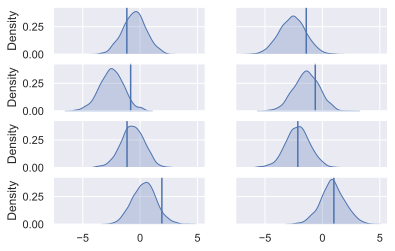

In [37]:
# Plot random datapoints and their prediction distributions
fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_dist_var[:, ix, 0]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])

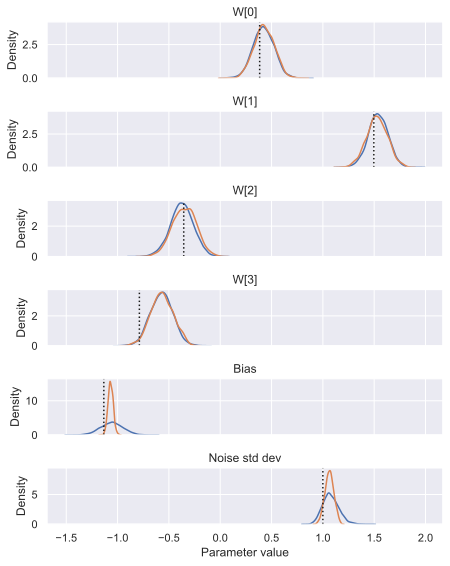

In [38]:
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 1, sharex='all')
fig.set_size_inches(6.4, 8)
for i in range(D):
  t_ax = axes[i]
  sns.kdeplot(coeffs_samples[:,i], #MCMC posterior
              ax=t_ax, label='MCMC') 
  sns.kdeplot(w_post[:,i,0], #variational posterior
              ax=t_ax, label='Variational') 
  t_ax.axvline(x=w_true[i], #true value
               color='k', linestyle=':') 
  t_ax.title.set_text('W[{}]'.format(i))
  
# Plot chains and distributions for bias
t_ax = axes[D]
sns.kdeplot(bias_samples[:,0], #MCMC posterior
            ax=t_ax, label='MCMC') 
sns.kdeplot(b_post[:,0], #variational posterior
            ax=t_ax, label='Variational') 
t_ax.axvline(x=b_true, #true value
             color='k', linestyle=':') 
t_ax.title.set_text('Bias')

# Plot chains and distributions for noise std dev
t_ax = axes[D+1]
sns.kdeplot(noise_std_samples[:,0], #MCMC posterior
            ax=t_ax, label='MCMC') 
sns.kdeplot(n_post[:,0], #variational estimate
            ax=t_ax, label='Variational') 
t_ax.axvline(x=noise_std_true, #true value
             color='k', linestyle=':') 
t_ax.title.set_text('Noise std dev')

axes[D+1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

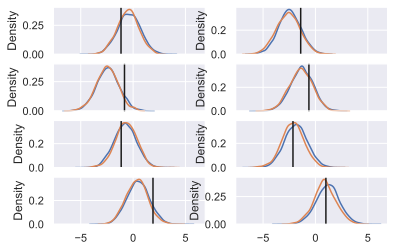

In [39]:
# Plot some datapoints and their prediction distributions
# as computed by MCMC and variational Bayes
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist_var = prediction_dist_var[:, ix, 0]
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, ax=axes[i][j])
    sns.kdeplot(pred_dist_var, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0], color='k')